<a href="https://colab.research.google.com/github/tulaycetin/Eksik_Versi_Temizleme/blob/main/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import random
import math
import csv
import matplotlib.pyplot as plt
import os
import numpy as np
import kagglehub
from sklearn.neighbors import NearestNeighbors
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer'ı etkinleştirir.
from sklearn.impute import IterativeImputer

# Kaggle veri setini indir
path = kagglehub.dataset_download("maxhorowitz/nflplaybyplay2009to2016")
filename = os.path.join(path, "NFL Play by Play 2009-2017 (v4).csv")


In [10]:

# Veri setini yükleyelim (10000 örnek ile sınırlı)
def load_data(filename, sample_size=10000):
    data = []
    with open(filename, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                # Gerekli sütunları alıp uygun tipte kaydedelim
                qtr = int(row['qtr'])
                down = int(row['down'])
                time_secs = float(row['TimeSecs'])
                win_prob = float(row['Win_Prob'])
                data.append([qtr, down, time_secs, win_prob])
            except ValueError:
                continue  # Hatalı satırları atla
    # Rastgele örnek seç
    data = random.sample(data, min(sample_size, len(data)))
    return data

In [11]:
 # MICE dönüşümünü uygulama (Eksik verileri doldur)
def apply_mice_imputation(data):
    # Veriyi numpy dizisine dönüştür
    data_np = np.array(data, dtype=float)

    # MICE (Multiple Imputation by Chained Equations) ile eksik verileri doldur
    imputer = IterativeImputer(max_iter=10, random_state=0)
    data_imputed = imputer.fit_transform(data_np)  # Veriyi doldur
    return data_imputed

In [12]:
# KNN ile aykırı değerleri tespit etme
def knn_outlier_removal(data, k=5, threshold=0.6):
    # Veriyi numpy array olarak dönüştür
    data_np = np.array(data)

    # 2D şekil sağlamak için, her veri satırını düzgün şekilde hizalayalım
    data_np = data_np.reshape(-1, len(data[0]))  # Veri kümesindeki her bir satır uzunluğu kadar

    # KNN modelini fit et
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data_np)
    distances, _ = nbrs.kneighbors(data_np)

    # En yakın komşuların ortalama mesafesi
    mean_distances = np.mean(distances[:, 1:], axis=1)  # İlk sütun kendisi olduğundan hariç tutulur
    threshold_value = np.mean(mean_distances) + threshold * np.std(mean_distances)

    # Aykırı olmayanları filtrele
    filtered_data = [data[i] for i in range(len(data)) if mean_distances[i] <= threshold_value]
    return filtered_data



In [13]:
# Min-Max Normalizasyonu
def normalize_data(data):
    min_vals = [min(col) for col in zip(*data)]
    max_vals = [max(col) for col in zip(*data)]
    normalized_data = [
        [(val - min_vals[i]) / (max_vals[i] - min_vals[i]) if max_vals[i] - min_vals[i] != 0 else 0
         for i, val in enumerate(row)]
        for row in data
    ]
    return normalized_data

# Öklid Mesafesi Hesaplama
def euclidean_distance(point1, point2):
    return math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))


In [14]:
# K-Means Kümeleme Algoritması
def k_means_clustering(data, k, max_iters=100):
    if k > len(data):
        k = len(data)  # Küme sayısını veri sayısına eşitle
        print(f"Veri kümesi büyüklüğünden dolayı k değeri {len(data)} olarak ayarlandı.")

    centroids = random.sample(data, k)
    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]

        # Her veri noktasını en yakın merkeze ata
        for point in data:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            cluster_index = distances.index(min(distances))
            clusters[cluster_index].append(point)

        # Yeni küme merkezlerini hesaplayalım
        new_centroids = []
        for cluster in clusters:
            if cluster:
                new_centroid = [sum(dim) / len(cluster) for dim in zip(*cluster)]
            else:
                all_points = [point for cluster in clusters for point in cluster]
                max_dist_point = max(all_points, key=lambda p: sum(euclidean_distance(p, c) for c in centroids))
                new_centroid = max_dist_point
            new_centroids.append(new_centroid)

        # Eğer merkezler değişmezse algoritma durur
        if new_centroids == centroids:
            break
        centroids = new_centroids

    return clusters, centroids


In [15]:


# Kümeleme sonuçlarını görselleştirme
def plot_clusters(clusters, centroids):
    colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta']
    markers = ['o', 's', 'D', '^', 'v', '*']
    for i, cluster in enumerate(clusters):
        x_vals = [point[2] for point in cluster]
        y_vals = [point[3] for point in cluster]
        plt.scatter(x_vals, y_vals, color=colors[i % len(colors)], marker=markers[i % len(markers)], alpha=0.5, label=f'Küme {i+1}')

    centroid_x = [centroid[2] for centroid in centroids]
    centroid_y = [centroid[3] for centroid in centroids]
    plt.scatter(centroid_x, centroid_y, color='red', marker='x', s=100, label='Centroids')

    plt.xlabel('TimeSecs')
    plt.ylabel('Win Probability')
    plt.title('K-Means Kümeleme Sonuçları')
    plt.legend()
    plt.show()

Küme 1: 1473 veri noktası
Küme 2: 2029 veri noktası
Küme 3: 1929 veri noktası
Küme 4: 1248 veri noktası
Küme 5: 3321 veri noktası
İlk Küme Merkezleri: [[np.float64(0.1415478615071283), np.float64(0.7875084860828211), np.float64(0.7807365353523232), np.float64(0.48670518553181297)], [np.float64(0.6368900936421883), np.float64(0.21751273205191218), np.float64(0.3804700584571549), np.float64(0.1720203429461954)], [np.float64(0.6115863141524106), np.float64(0.13720407810610113), np.float64(0.40698454765994835), np.float64(0.8036789270203811)], [np.float64(0.6438301282051282), np.float64(0.8071581196581107), np.float64(0.3813728216536902), np.float64(0.5845627142980203)], [np.float64(0.13053297199638664), np.float64(0.1426277225735192), np.float64(0.7949834186266719), np.float64(0.5138954193804806)]]


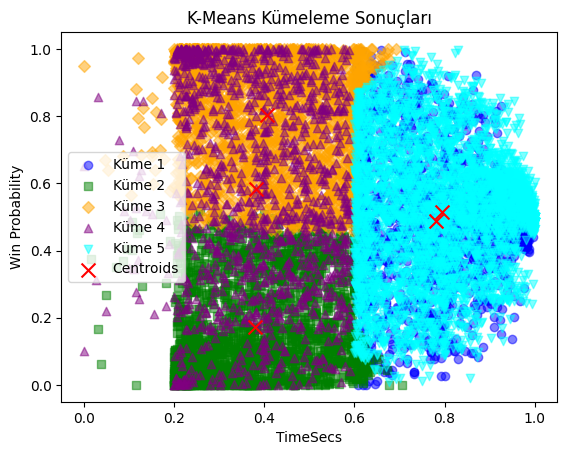

Küme 1: 1843 veri noktası
Küme 2: 2324 veri noktası
Küme 3: 732 veri noktası
Küme 4: 1875 veri noktası
Küme 5: 1843 veri noktası
Aykırı Değer Temizlenmiş Küme Merkezleri: [[np.float64(0.6276451437873033), np.float64(0.2116115029842637), np.float64(0.3923488870795735), np.float64(0.845184770552804)], [np.float64(0.12317125645438898), np.float64(0.5060240963855437), np.float64(0.8011565728989395), np.float64(0.5127122084509058)], [np.float64(0.5806010928961749), np.float64(0.7959927140255021), np.float64(0.42369299221357026), np.float64(0.33809997358972926)], [np.float64(0.1392), np.float64(0.0), np.float64(0.7874954393770859), np.float64(0.538496900376359)], [np.float64(0.6215409658166033), np.float64(0.14053174172544913), np.float64(0.3919095009406368), np.float64(0.1996615048269988)]]


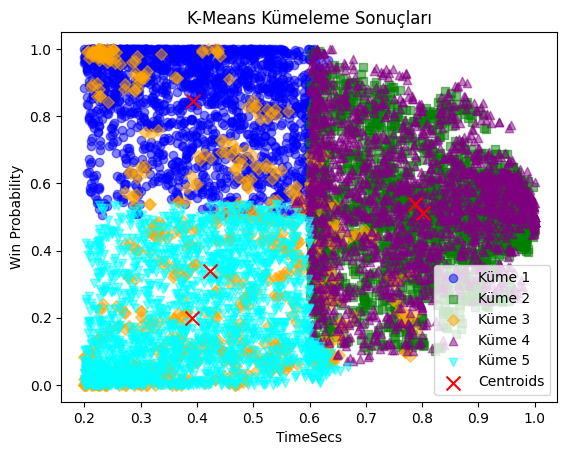

In [17]:
# Ana Program
data = load_data(filename, sample_size=10000)

# 1) MICE ile eksik değer doldurma
data_imputed = apply_mice_imputation(data)

# 2) Normalizasyon (MICE sonrası)
data_normalized = normalize_data(data_imputed)

# 3) K-Means kümeleme (normalleştirilmiş veri)
k = 5
clusters, centroids = k_means_clustering(data_normalized, k)

# İlk kümeleme sonuçlarını yazdır
for i, cluster in enumerate(clusters):
    print(f'Küme {i + 1}: {len(cluster)} veri noktası')
print("İlk Küme Merkezleri:", centroids)

# İlk kümeleme görselleştirme
plot_clusters(clusters, centroids)

# 4) Aykırı değer temizleme (normalize edilmiş veri üzerinde)
data_knn_filtered = knn_outlier_removal(data_normalized, k=5, threshold=0.6)

# 5) Tekrar K-Means (aykırı değerler atıldıktan sonra)
clusters, centroids = k_means_clustering(data_knn_filtered, k)

# İkinci (temizlenmiş) kümeleme sonuçlarını yazdır
for i, cluster in enumerate(clusters):
    print(f'Küme {i + 1}: {len(cluster)} veri noktası')
print("Aykırı Değer Temizlenmiş Küme Merkezleri:", centroids)

# İkinci kümeleme görselleştirme
plot_clusters(clusters, centroids)

